In [27]:
import numpy as np
from scipy.optimize import linprog
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gmean

In [24]:
def CVaR_optimization(expected_returns, return_std_devs, alpha, num_scenarios):

    num_bonds = 100 # Number of bonds in the portfolio
    
    simulated_returns = np.random.normal(loc=expected_returns, scale=return_std_devs, size=(num_scenarios, num_bonds))
    
    c = np.concatenate([np.zeros(num_bonds), np.ones(num_scenarios) / ((1 - alpha) * num_scenarios), [1]])
    
    A = np.block([
        [-simulated_returns, -np.eye(num_scenarios), -np.ones((num_scenarios, 1))]
    ])
    
    b = np.zeros(num_scenarios)

    A_eq = np.concatenate([np.ones(num_bonds), np.zeros(num_scenarios + 1)]).reshape(1, -1)

    b_eq = [1]
    
    bounds = [(0, None)] * num_bonds + [(0, None)] * num_scenarios + [(None, None)]
    
    
    result = linprog(c, A_ub=A, b_ub=b, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    optimal_weights = result.x[:num_bonds]
    
    if result.success:
        return optimal_weights
    else:
        raise ValueError("Optimization failed: " + result.message)

/var/folders/1b/p83v8krd07n4wstbm7mf_2_w0000gn/T/ipykernel_72309/3205680525.py:44: RuntimeWarning: overflow encountered in multiply
  currentVal[period + 1] = currentVal[period] * (1 + portfolio_return)


(365,)
Sharpe ratio:  1.3170575589354263
Avg. turnover:  0.4999999999999989


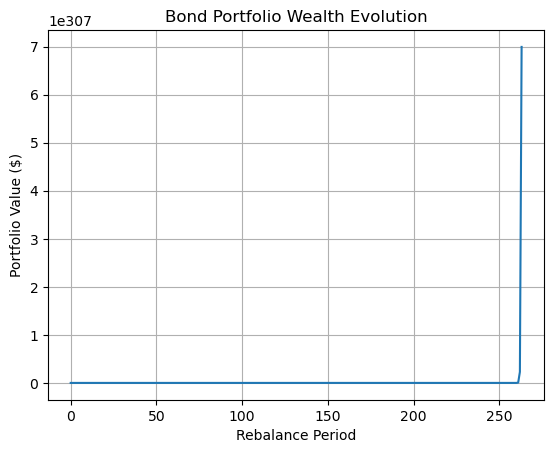

<Figure size 640x480 with 0 Axes>

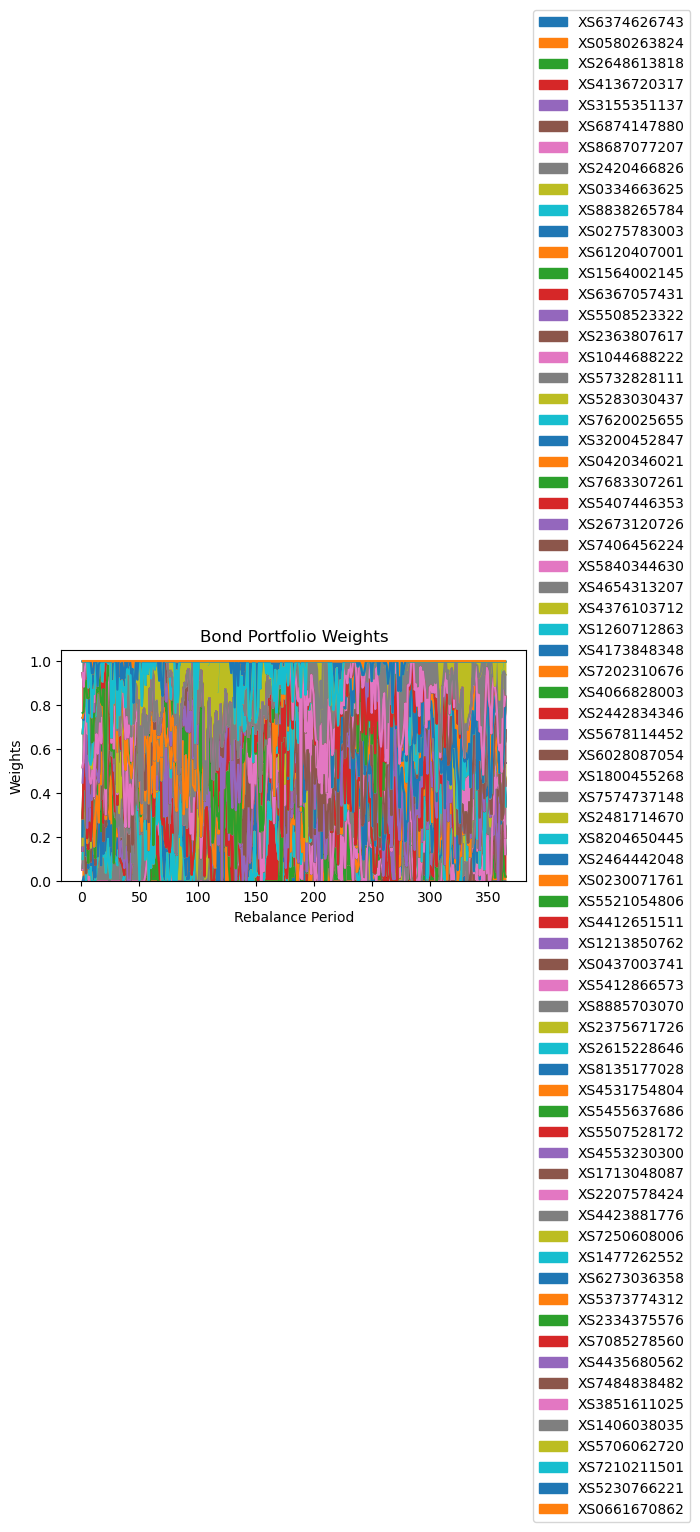

In [28]:
bond_data = pd.read_csv('bond_data.csv')
bond_data['Date'] = pd.to_datetime(bond_data['Date'])

# Initial budget to invest ($100,000)
initialVal = 100000  

# Length of investment period (in months)
investPeriod = 1

#Identify the tickers and the dates
tickers = bond_data['ISIN'].unique()
dates = bond_data['Date'].unique()

n = len(tickers)   # Number of bonds
NoPeriods = len(dates) // investPeriod  
# Preallocate space for portfolio weights (x0 will track turnover)
x = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])

# Preallocate space for portfolio value and turnover
currentVal = np.zeros([NoPeriods + 1, 1])
currentVal[0] = initialVal
portfolio_returns = np.zeros(NoPeriods)
turnover = np.zeros([NoPeriods, 1])

rf = 0.02/365

# Iterate through investment periods
for period in range(NoPeriods):
    # Select bonds available during this period
    current_bonds = bond_data[bond_data['Date'] == dates[period * investPeriod]]

    #placeholder
    weights = CVaR_optimization(current_bonds["expected_return"], current_bonds["return_std_dev"], 0.95, 100)
    
    # Store weights
    x[:, period] = weights
    
    # Calculate expected portfolio return and risk based on the bonds
    portfolio_return = np.sum(weights * current_bonds['expected_return'])
    portfolio_risk = np.sqrt(np.sum((weights**2) * (current_bonds['return_std_dev']**2)))
    
    # Simulate the portfolio value evolution
    currentVal[period + 1] = currentVal[period] * (1 + portfolio_return)
    
    portfolio_returns[period] = portfolio_return

    # Calculate turnover (assume full rebalance between periods)
    turnover[period] = np.sum(np.abs(weights - x0[:, period])) / 2
    x0[:, period] = weights



excess_returns = portfolio_returns - rf

print(excess_returns.shape)
SR = (gmean(excess_returns + 1) - 1)/excess_returns.std()

avgTurnover = np.mean(turnover[1:])
print('Sharpe ratio: ', str(SR))
print('Avg. turnover: ', str(avgTurnover))

# --------------------------------------------------------------------------
# 3.1 Plot portfolio wealth evolution
# --------------------------------------------------------------------------
plt.figure(1)
plt.plot(np.arange(0, NoPeriods + 1), currentVal, label='Portfolio Value')
plt.title('Bond Portfolio Wealth Evolution')
plt.xlabel('Rebalance Period')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.savefig("bond_wealth_evolution.png")
plt.show()

# --------------------------------------------------------------------------
# 3.2 Plot portfolio weights per rebalance period
# --------------------------------------------------------------------------
fig2 = plt.figure(2)
x[x < 0] = 0
weights = pd.DataFrame(x[(x > 0).any(axis=1)], index=tickers[(x > 0).any(axis=1)])
weights.columns = [col + 1 for col in weights.columns]
weights.T.plot.area(title='Bond Portfolio Weights',
                    ylabel='Weights',
                    xlabel='Rebalance Period',
                    figsize=(6, 3),
                    legend=True,
                    stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("bond_weights.png")
plt.show()